# 0. Importing and Installing Dependancies

In [93]:
!pip install opencv-python opencv-python-headless numpy scikit-learn matplotlib pillow

In [95]:
pip install --upgrade imutils

Note: you may need to restart the kernel to use updated packages.


In [96]:
import cv2                    # For image processing
import numpy as np            # For array operations
from sklearn.mixture import GaussianMixture  # For Expectation Maximization clustering
import matplotlib.pyplot as plt  # For displaying images
from PIL import Image         # For handling images


In [99]:
import imutils

## 1. Preprocessing the Images

In [102]:
import os
input_dir = 'images'
output_dir = 'out_imgs'

In [104]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize image
    image = cv2.resize(image, (640, 480))
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Noise Reduction
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    
    # Perform Canny Edge Detection
    edges = cv2.Canny(bfilter, 30, 200)

    # Locate the region of interest (ROI) by finding contours
    keypoints = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    flocation = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
            
    # Check if location was found
    if location is None:
        print(f"No license plate contour found in image: {image_path}")
        return None  # or return the original image if preferred
    
    # Create a mask to keep only the largest contour, assuming it’s the license plate
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)

    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]

    return cropped_image


In [106]:
for image in os.listdir(input_dir):
    # Check if the file is an image
    if image.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_dir, image)
        
        # Preprocess the image
        processed_image = preprocess_image(image_path)
        
        # Save the processed image to the output directory
        output_path = os.path.join(output_dir, image)
        cv2.imwrite(output_path, processed_image)

## 2.Segmentation using Expectation Maximization method

In [109]:
segmented_output_dir = 'segmented_images'
os.makedirs(segmented_output_dir, exist_ok=True)

In [111]:
def em_segmentation(image):
    # Flatten the image
    pixels = image.reshape(-1, 1)  # Reshape to a single column for GMM

    # Initialize Gaussian Mixture Model with 2 components (background and foreground)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(pixels)

    # Predict the cluster for each pixel
    labels = gmm.predict(pixels)
    segmented_image = labels.reshape(image.shape)  # Reshape back to the image shape

    # Optionally: Use binary thresholding for better visualization
    segmented_image = (segmented_image * 255).astype(np.uint8)  # Convert labels to binary image

    return segmented_image

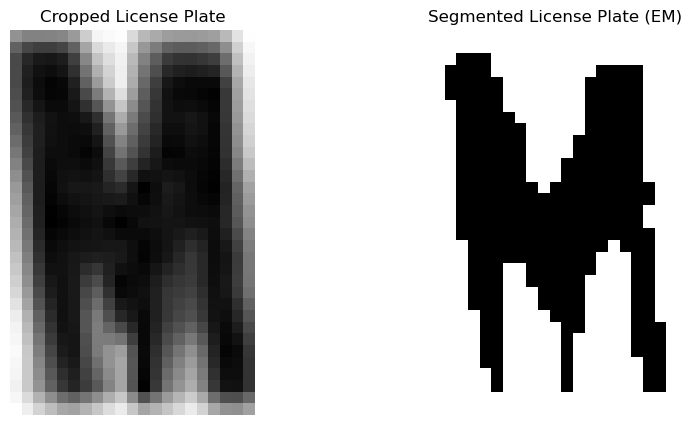

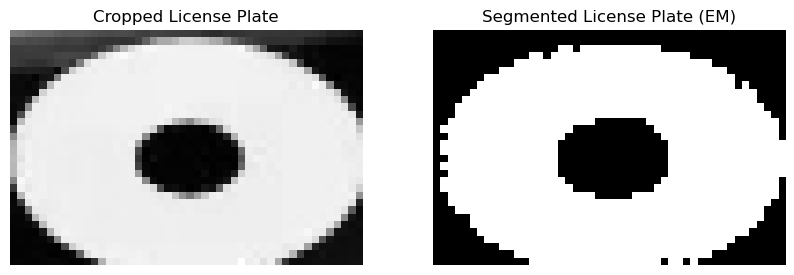

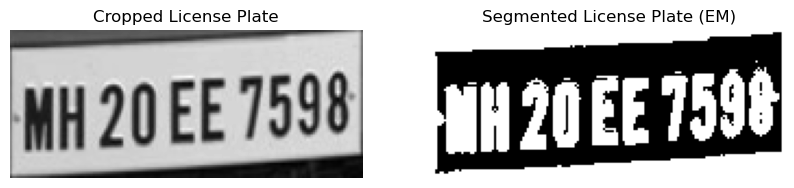

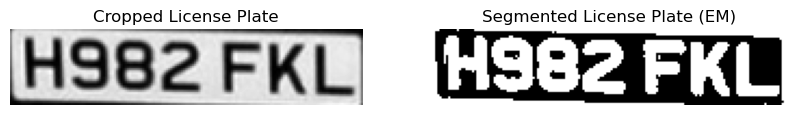

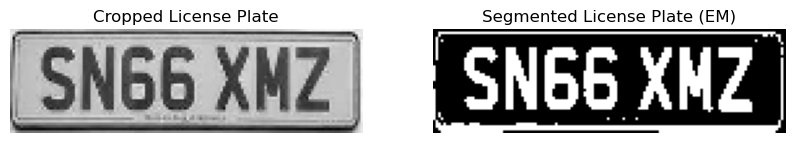

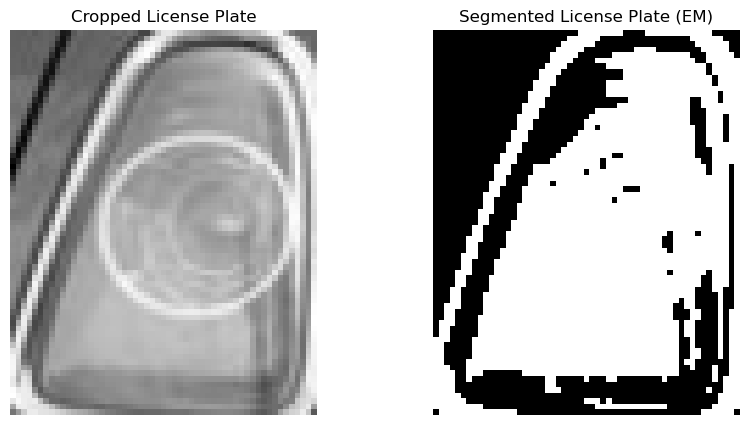

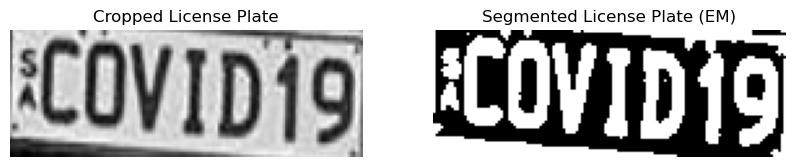

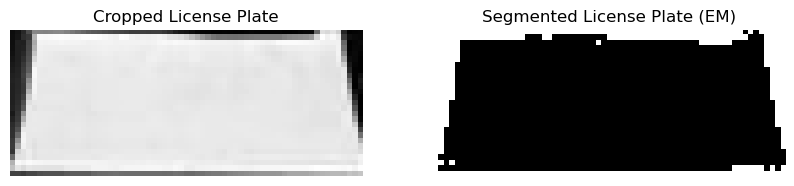

In [113]:
for image in os.listdir(input_dir):
    # Check if the file is an image
    if image.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_dir, image)

        # Preprocess the image to get the cropped license plate
        cropped_image = preprocess_image(image_path)

        # Check if a valid cropped image was returned
        if cropped_image is not None:
            # Apply EM Segmentation
            segmented_image = em_segmentation(cropped_image)

            # Save the segmented image to the segmented output directory
            output_path = os.path.join(segmented_output_dir, f"segmented_{image}")
            cv2.imwrite(output_path, segmented_image)

            # Display the original and segmented images
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Cropped License Plate")
            plt.imshow(cropped_image, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Segmented License Plate (EM)")
            plt.imshow(segmented_image, cmap='gray')
            plt.axis('off')

            plt.show()

## 3. Optical Character Recognition (OCR)

In [116]:
!/opt/anaconda3/bin/python -m pip install pytesseract

In [117]:
import pytesseract

In [132]:
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"  # Adjust the path if necessary

In [134]:
def extract_text_from_image(image):
    # Use pytesseract to do OCR on the image
    text = pytesseract.image_to_string(image, config='--psm 8')  # --psm 8 is for single word detection
    return text.strip()

Extracted text from image8.jpg: ¥


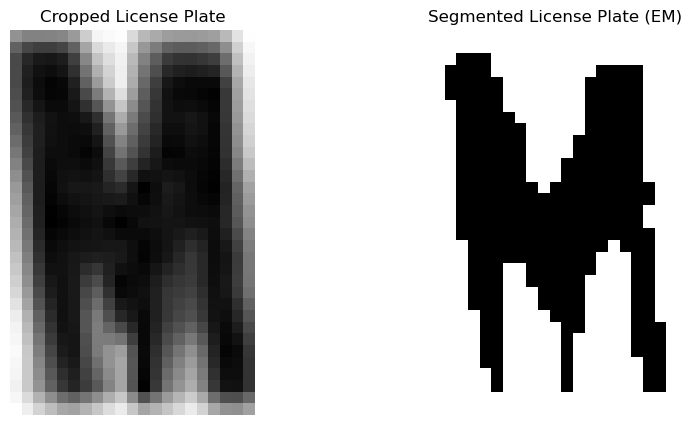

Extracted text from image7.jpg: <>


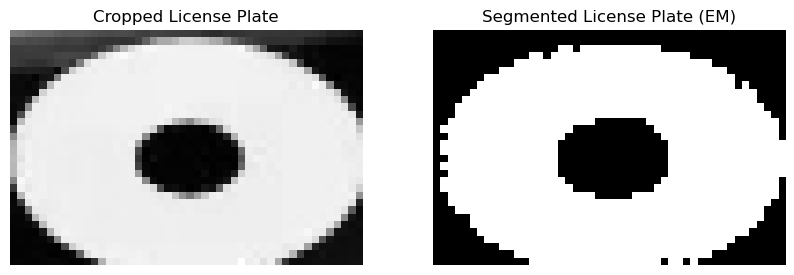

Extracted text from image6.jpg: nH 20 £6 7598


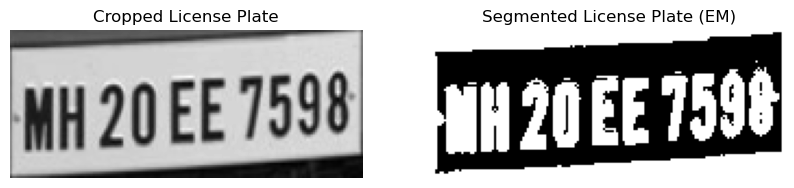

Extracted text from image4.jpg: H9382 FKL


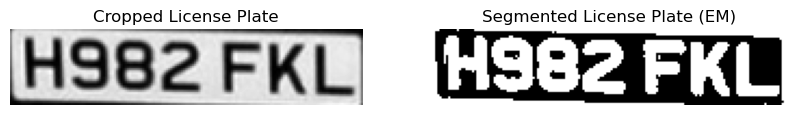

Extracted text from image5.jpg: -SN66 XMZ_


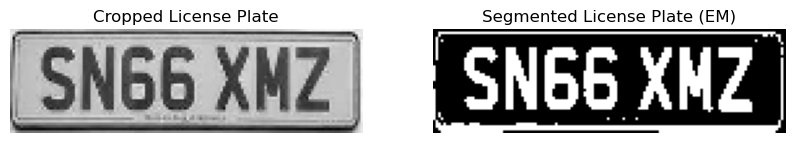

Extracted text from image1.jpg: a


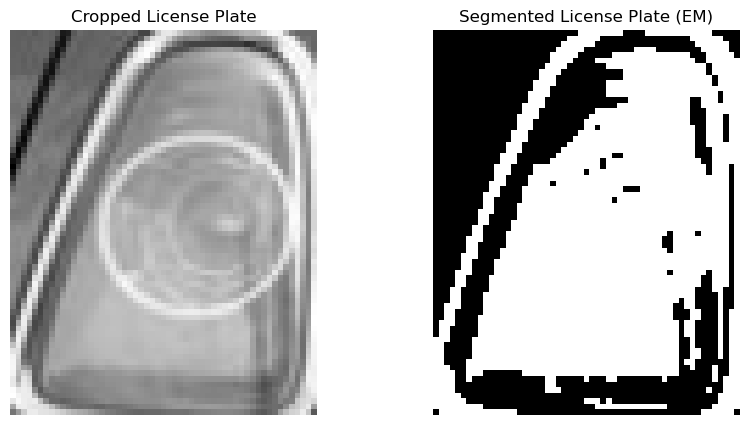

Extracted text from image2.jpg: ‘COVIDI9


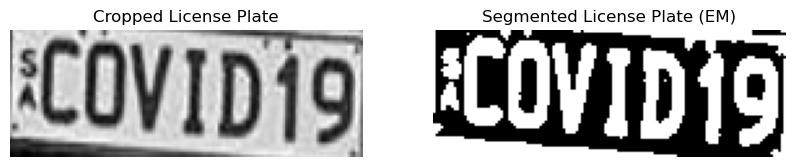

Extracted text from image3.jpg: Ff


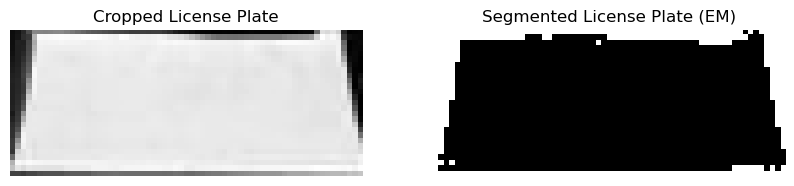

In [136]:
for image in os.listdir(input_dir):
    # Check if the file is an image
    if image.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_dir, image)

        # Preprocess the image to get the cropped license plate
        cropped_image = preprocess_image(image_path)

        # Check if a valid cropped image was returned
        if cropped_image is not None:
            # Apply EM Segmentation
            segmented_image = em_segmentation(cropped_image)

            # Save the segmented image to the segmented output directory
            output_path = os.path.join(segmented_output_dir, f"segmented_{image}")
            cv2.imwrite(output_path, segmented_image)

            # OCR on the segmented image
            extracted_text = extract_text_from_image(segmented_image)

            # Print or save the extracted text (license plate number)
            print(f"Extracted text from {image}: {extracted_text}")

            # Optionally: You can save the result to a file or display it
            with open(os.path.join(segmented_output_dir, f"{image}_extracted_text.txt"), 'w') as f:
                f.write(extracted_text)

            # Display the original and segmented images
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Cropped License Plate")
            plt.imshow(cropped_image, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Segmented License Plate (EM)")
            plt.imshow(segmented_image, cmap='gray')
            plt.axis('off')

            plt.show()